# Predict MVP 2022 TEST


In [1]:
import pickle
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import commonallplayers #per avere l'elenco dei giocatori (id)
from nba_api.stats.endpoints import playercareerstats #per avere i dati
from nba_api.stats.endpoints import playerawards #per sapere chi ha vinto MVP
from nba_api.stats.endpoints import teamyearbyyearstats #classifiche finali delle squadre
import pandas as pd
from tqdm import tqdm
import pickle

## Scarico i giocatori 2022

In [2]:
from_year = 2021

total_players = commonallplayers.CommonAllPlayers().get_data_frames()[0]
total_players['TO_YEAR'] = total_players['TO_YEAR'].astype('int')
total_players = total_players[total_players['TO_YEAR'] == from_year]

#Ho controllato che in total_players, il PERSON_ID sia univoco
total_players

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,PLAYER_SLUG,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,TEAM_SLUG,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH
10,1630173,"Achiuwa, Precious",Precious Achiuwa,1,2020,2021,precious_achiuwa,precious_achiuwa,1610612761,Toronto,Raptors,TOR,raptors,raptors,Y,00
22,203500,"Adams, Steven",Steven Adams,1,2013,2021,steven_adams,steven_adams,1610612763,Memphis,Grizzlies,MEM,grizzlies,grizzlies,Y,00
24,1628389,"Adebayo, Bam",Bam Adebayo,1,2017,2021,bam_adebayo,bam_adebayo,1610612748,Miami,Heat,MIA,heat,heat,Y,00
40,1630583,"Aldama, Santi",Santi Aldama,1,2021,2021,santi_aldama,santi_aldama,1610612763,Memphis,Grizzlies,MEM,grizzlies,grizzlies,Y,11
43,200746,"Aldridge, LaMarcus",LaMarcus Aldridge,1,2006,2021,lamarcus_aldridge,lamarcus_aldridge,1610612751,Brooklyn,Nets,BKN,nets,nets,Y,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701,201152,"Young, Thaddeus",Thaddeus Young,1,2007,2021,thaddeus_young,thaddeus_young,1610612759,San Antonio,Spurs,SAS,spurs,spurs,Y,00
4703,1629027,"Young, Trae",Trae Young,1,2018,2021,trae_young,trae_young,1610612737,Atlanta,Hawks,ATL,hawks,hawks,Y,00
4704,1630209,"Yurtseven, Omer",Omer Yurtseven,1,2020,2021,tmp_omer_yurtseven,omer_yurtseven,1610612748,Miami,Heat,MIA,heat,heat,Y,01
4707,203469,"Zeller, Cody",Cody Zeller,1,2013,2021,cody_zeller,cody_zeller,1610612757,Portland,Trail Blazers,POR,blazers,blazers,Y,00


In [ ]:
# all_teams_history = list(total_players["TEAM_ID"].drop_duplicates())
# data_all_team_stats = pd.DataFrame()
#
# for team in all_teams_history:
#     t = teamyearbyyearstats.TeamYearByYearStats(team_id=team).get_data_frames()[0]
#     #t["SEASON_ID"] = t[t["SEASON_ID"] == "2021-22"] # Non cambia tanto perchè nel get prende tutti
#     data_all_team_stats = pd.concat([data_all_team_stats, t], axis=0, ignore_index=True)
#
# data_all_team_stats = data_all_team_stats.rename(columns={"YEAR": "SEASON_ID"})
# data_all_team_stats = data_all_team_stats[["TEAM_ID", "SEASON_ID", "CONF_RANK"]]
#
# with open("data_all_team_stats_2022.pkl",'wb') as f:
#     pickle.dump(data_all_team_stats,f)
#
# data_all_team_stats

In [3]:
total_names = total_players[["PERSON_ID", "DISPLAY_FIRST_LAST"]]
total_stats = pd.DataFrame()
with open("data_all_team_stats_2022.pkl", "rb") as f:
    data_all_team_stats = pickle.load(f)

for index, row in tqdm(total_names.iterrows()):
    stats = playercareerstats.PlayerCareerStats(player_id=row["PERSON_ID"]).get_data_frames()[0]

    stats = stats.drop(stats.columns[[2, 4, 7]], axis=1)

    awards = playerawards.PlayerAwards(player_id=row["PERSON_ID"]).get_data_frames()[0]

    awards = awards.drop(awards.columns[[0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13]], axis=1) #Tolgo anche PERSON_ID
    awards = awards.rename(columns={"SEASON": "SEASON_ID"})
    awards = awards.loc[awards["DESCRIPTION"]=="NBA Most Valuable Player"]

    #merge
    stats=stats.merge(awards, how="left", on="SEASON_ID")
    #1 to MVP, 0 to other
    stats["DESCRIPTION"] = stats["DESCRIPTION"].replace("NBA Most Valuable Player", 1) #Replace the description MVP with 1
    stats["DESCRIPTION"] = stats["DESCRIPTION"].fillna(0) #Replace NULL with 0
    stats = stats.rename(columns={"DESCRIPTION": "MVP"})

    #merge della classifica in cui è arrivata la squadra in una certa stagione
    stats = stats.merge(data_all_team_stats, how="inner", on=["SEASON_ID", "TEAM_ID"])

    total_stats = pd.concat([total_stats, stats],axis=0,ignore_index=True)


#Tolgo la formattazione "year1-year2" (2010-11) e lascio solo il secondo anno (2011)
total_stats["SEASON_ID"] = [int("20"+x.split("-")[1]) for x in list(total_stats["SEASON_ID"])] #Problema se si prendono dati < anno 2000
#Prendo i dati superiore all'anno FROM_YEAR
total_stats= total_stats[total_stats["SEASON_ID"] > from_year]


with open("player_stats_2022.pkl",'wb') as f:
    pickle.dump(total_stats,f)

608it [19:13,  1.90s/it]


## Predizione 2022, preparo i dati appena scaricati

In [4]:
with open("player_stats_2022.pkl", "rb") as f:
    season_2021 = pickle.load(f)
#tolgo seasons che non ci servono
season_2021 = season_2021[season_2021["SEASON_ID"] == 2022]


#sposto la colonna MVP per prima per comodita
cols = season_2021.columns.tolist()
cols = cols[-2:] + cols[:-2]
season_2021 = season_2021[cols]

season_2021["GP"]=season_2021["GP"].astype('int')
season_2021["FGM"]=season_2021["FGM"].astype('int')
season_2021["FGA"]=season_2021["FGA"].astype('int')
season_2021["FG3M"]=season_2021["FG3M"].astype('int')
season_2021["FG3A"]=season_2021["FG3A"].astype('int')
season_2021["FTM"]=season_2021["FTM"].astype('int')
season_2021["FTA"]=season_2021["FTA"].astype('int')
season_2021["OREB"]=season_2021["OREB"].astype('int')
season_2021["DREB"]=season_2021["DREB"].astype('int')
season_2021["REB"]=season_2021["REB"].astype('int')
season_2021["AST"]=season_2021["AST"].astype('int')
season_2021["STL"]=season_2021["STL"].astype('int')
season_2021["BLK"]=season_2021["BLK"].astype('int')
season_2021["TOV"]=season_2021["TOV"].astype('int')
season_2021["PF"]=season_2021["PF"].astype('int')
season_2021["PTS"]=season_2021["PTS"].astype('int')


season_2021

,MVP,CONF_RANK,PLAYER_ID,SEASON_ID,TEAM_ID,PLAYER_AGE,GP,MIN,FGM,FGA,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
1,0.0,8,1630173,2022,1610612761,22.0,42,1013.0,137,322,...,0.545,96,208,304,49,22,27,42,87,326
10,0.0,3,203500,2022,1610612763,28.0,50,1311.0,125,243,...,0.573,220,254,474,151,48,33,80,87,325
15,0.0,3,1628389,2022,1610612748,24.0,28,933.0,191,364,...,0.764,76,204,280,99,43,17,83,92,508
16,0.0,3,1630583,2022,1610612763,21.0,27,277.0,37,97,...,0.600,23,41,64,14,2,7,9,27,90
33,0.0,2,200746,2022,1610612751,36.0,36,825.0,207,373,...,0.853,54,148,202,31,13,39,32,63,484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3336,0.0,12,201152,2022,1610612759,33.0,26,370.0,74,128,...,0.455,40,53,93,59,23,7,30,38,158
3340,0.0,12,1629027,2022,1610612737,23.0,47,1625.0,443,970,...,0.892,30,159,189,435,48,4,194,75,1313
3341,0.0,3,1630209,2022,1610612748,23.0,37,547.0,99,189,...,0.640,66,165,231,41,15,18,34,67,231
3350,0.0,10,203469,2022,1610612757,29.0,27,355.0,51,90,...,0.776,50,75,125,22,8,6,19,56,140


In [5]:
#standardizzazione i nostri dati per anno

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

num_cols = season_2021.columns
num_cols = num_cols.drop(["MVP",'CONF_RANK', 'PLAYER_ID', 'SEASON_ID', 'TEAM_ID'])

season_2021_norm=pd.DataFrame()
season_2021_norm = pd.concat([season_2021_norm, season_2021],axis=0,ignore_index=True)


In [6]:

for col in num_cols.tolist():
    season_2021_norm[[col]] = scaler.fit_transform(season_2021[[col]].to_numpy().reshape(-1,1))

season_2021_norm

,MVP,CONF_RANK,PLAYER_ID,SEASON_ID,TEAM_ID,PLAYER_AGE,GP,MIN,FGM,FGA,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,0.0,8,1630173,2022,1610612761,-0.929611,0.860350,0.741159,0.329215,0.423458,...,-0.316168,2.157283,1.323123,1.604114,-0.153074,0.133208,0.907689,0.222727,0.898943,0.170034
1,0.0,3,203500,2022,1610612763,0.523708,1.321374,1.290858,0.217868,0.085640,...,-0.222848,5.989125,1.826629,3.034179,1.119291,1.464303,1.276968,1.220239,0.898943,0.166659
2,0.0,3,1628389,2022,1610612748,-0.445171,0.053558,0.593589,0.830276,0.603057,...,0.413731,1.539244,1.279340,1.402223,0.470634,1.208323,0.292223,1.298990,1.017531,0.784306
3,0.0,3,1630583,2022,1610612763,-1.171831,-0.004070,-0.616488,-0.598676,-0.538681,...,-0.132860,-0.098559,-0.504824,-0.414801,-0.589670,-0.890711,-0.323243,-0.643533,-0.524108,-0.626493
4,0.0,2,200746,2022,1610612751,2.461468,0.514582,0.394369,0.978738,0.641542,...,0.710357,0.859401,0.666375,0.746075,-0.377609,-0.327555,1.646248,-0.039776,0.329723,0.703303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,0.0,12,201152,2022,1610612759,1.734808,-0.061698,-0.444938,-0.255356,-0.406119,...,-0.616127,0.426774,-0.373475,-0.170849,-0.028332,0.184404,-0.323243,-0.092276,-0.263215,-0.396985
619,0.0,12,1629027,2022,1610612737,-0.687391,1.148490,1.870072,3.168560,3.194416,...,0.840339,0.117755,0.786779,0.636717,4.661954,1.464303,-0.507883,4.212775,0.614333,3.501274
620,0.0,3,1630209,2022,1610612748,-0.687391,0.572210,-0.118438,-0.023383,-0.145273,...,0.000455,1.230225,0.852454,0.990027,-0.252867,-0.225164,0.353769,0.012725,0.424593,-0.150602
621,0.0,10,203469,2022,1610612757,0.765928,-0.004070,-0.472607,-0.468771,-0.568614,...,0.453726,0.735794,-0.132667,0.098340,-0.489876,-0.583535,-0.384790,-0.381030,0.163700,-0.457737


## Predict 2022

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
test_2021_labels = season_2021_norm[["MVP"]]

name_model = "log_reg"

# with open("svm_40.pkl", "rb") as f:
with open(name_model+".pkl", "rb") as f:
# with open("svm.pkl", "rb") as f:
# with open("rf.pkl", "rb") as f:
# with open("log_reg.pkl", "rb") as f:

    log_reg = pickle.load(f)


    ###                             ###

# train_2021 = season_2021_norm[["CONF_RANK", "GP", "MIN", "FGM", "FG_PCT", "FG3M", "FG3_PCT", "FTM", "FT_PCT", "OREB", "DREB", "AST", "STL", "BLK", "TOV", "PF"]]
train_2021 = season_2021_norm[["CONF_RANK", "GP", "MIN", "FG_PCT", "FG3M", "FG3_PCT", "FTM", "FT_PCT", "OREB", "DREB", "AST", "STL", "BLK", "PF"]]
# train_2021 = season_2021_norm.drop(["MVP", 'PLAYER_ID', 'SEASON_ID', 'TEAM_ID', "PLAYER_AGE"], axis=1)


predicted_labels = log_reg.predict(train_2021)
print(f"The balanced accuracy score is  {balanced_accuracy_score(test_2021_labels,predicted_labels)}")

The balanced accuracy score is  0.9951845906902087


/home/thomas/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [8]:
#Unisco i dataset
predict_2021 = pd.DataFrame(predicted_labels, columns=["MVP_Predict"])
predict_2021["PLAYER_ID"] = list(season_2021["PLAYER_ID"])

winners_id = predict_2021.loc[predict_2021["MVP_Predict"] == 1, "PLAYER_ID"]

In [9]:
from nba_api.stats.static import players

for id in list(winners_id):
    print(players.find_player_by_id(id))

{'id': 201942, 'full_name': 'DeMar DeRozan', 'first_name': 'DeMar', 'last_name': 'DeRozan', 'is_active': True}
{'id': 201935, 'full_name': 'James Harden', 'first_name': 'James', 'last_name': 'Harden', 'is_active': True}
{'id': 101108, 'full_name': 'Chris Paul', 'first_name': 'Chris', 'last_name': 'Paul', 'is_active': True}


### PROBABILITIES 2021

In [10]:

# test_2021_labels = season_2021_norm[["MVP"]]
#
# with open("log_reg.pkl", "rb") as f:
#     log_reg = pickle.load(f)

#train_2021 = season_2021_norm[["GP", "MIN", "FGM", "FG_PCT", "FG3M", "FG3_PCT", "FTM", "FT_PCT", "OREB", "DREB", "AST", "STL", "BLK", "TOV", "PF", 'CONF_RANK']]
predicted_labels = pd.DataFrame(log_reg.predict_proba(train_2021))

predicted_labels.rename(columns={0:'NOT',1:'MVP'},inplace=True)

predicted_labels = pd.DataFrame(predicted_labels, columns=["MVP"])
predicted_labels["PLAYER_ID"] = list(season_2021["PLAYER_ID"])

#Sort
mvp_candidates = predicted_labels.sort_values(by='MVP',ascending=False)

#Take only better
mvp_candidates = mvp_candidates.head(10)

mvp_candidates_names = pd.DataFrame()
# for row, id in mvp_candidates["PLAYER_ID"].iterrows():
#     name_player = players.find_player_by_id(id["PLAYER_ID"])
#     if name_player is not None:
#         name = pd.DataFrame.from_dict(name_player, orient="index")
#
#         name = name.transpose()
#         name["mvp_prob"] = list(id["MVP"])
#         mvp_candidates_names = pd.concat([mvp_candidates_names,name], axis=0, ignore_index=True)

for id in list(mvp_candidates["PLAYER_ID"]):
    name_player = players.find_player_by_id(id)
    name = pd.DataFrame.from_dict(name_player, orient="index")

    name = name.transpose()
    mvp_candidates_names = pd.concat([mvp_candidates_names,name], axis=0, ignore_index=True)

mvp_candidates_names["mvp_prob"] = list(mvp_candidates["MVP"])
mvp_candidates_names

,id,full_name,first_name,last_name,is_active,mvp_prob
0,201935,James Harden,James,Harden,True,0.992424
1,101108,Chris Paul,Chris,Paul,True,0.967933
2,201942,DeMar DeRozan,DeMar,DeRozan,True,0.611086
3,201142,Kevin Durant,Kevin,Durant,True,0.164059
4,201939,Stephen Curry,Stephen,Curry,True,0.160973
5,203897,Zach LaVine,Zach,LaVine,True,0.076319
6,1629630,Ja Morant,Ja,Morant,True,0.033209
7,203999,Nikola Jokic,Nikola,Jokic,True,0.022776
8,203507,Giannis Antetokounmpo,Giannis,Antetokounmpo,True,0.017760
9,202696,Nikola Vucevic,Nikola,Vucevic,True,0.007870


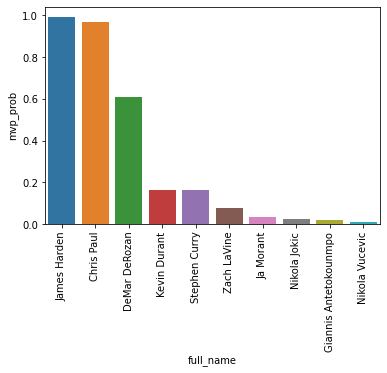

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
#mvp_candidates_names.plot.bar(x='full_name',y='mvp_prob' )
sns.barplot(x='full_name',y='mvp_prob',data=mvp_candidates_names.head(10))
plt.xticks(rotation=90)
plt.savefig('plot/'+name_model+'_2022.png', bbox_inches='tight')